In [51]:
import sys,os
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import plotting
import pandas as pd
from root_pandas import read_root, to_root
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ks_2samp
import xgboost as xgb

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [52]:
#Bc -> tau nu signal with the Z -> qq and cc BDT already applied
path = f"{loc.OUT}/ROOT"
df_sig = read_root(f"{path}/Bc2TauNu_Zuds_BDT_Zcc_BDT.root","events")

In [53]:
#Z -> bb inclusive with the Z -> qq and cc BDT applied
df_bkg = read_root(f"{path}/inclusive_Zbb_Zuds_BDT_Zcc_BDT.root","events")

In [54]:
#Variables to use in the MVA
training_vars = ["EVT_thrutshemis_e_min",
                 "EVT_thrutshemis_e_max",
                 "echarged_min",
                 "echarged_max",
                 "eneutral_min",
                 "eneutral_max",
                 "ncharged_min",
                 "ncharged_max",
                 "nneutral_min",
                 "nneutral_max"
                ]

In [55]:
#Keep only these variables
df_sig = df_sig[training_vars]
print("N_sig = %s" % len(df_sig))
df_bkg = df_bkg[training_vars]
print("N_bkg = %s" % len(df_bkg))

N_sig = 12637
N_bkg = 999246


In [56]:
#Signal and background labels
df_sig["label"] = 1
df_bkg["label"] = 0

#Combine the datasets
df_tot = df_sig.append(df_bkg)

In [57]:
#Split into class label (y) and training vars (x)
y = df_tot["label"]
x = df_tot[training_vars]

In [58]:
#Split into samples to be used in the two BDTs, which will be used to make predictions for each other
x_A, x_B, y_A, y_B = train_test_split(x, y, test_size=0.5, random_state=100)

In [59]:
#Sample weights to balance the classes
weights_A = compute_sample_weight(class_weight='balanced', y=y_A)
weights_B = compute_sample_weight(class_weight='balanced', y=y_B)

In [60]:
#BDTs for each sample, which we will apply to the other sample (cross BDT)
config_dict = {
        "n_estimators": 400,
        "learning_rate": 0.3,
        "max_depth": 3,
        }

bdt_A = xgb.XGBClassifier(n_estimators=config_dict["n_estimators"], 
                                   max_depth=config_dict["max_depth"], 
                                   learning_rate=config_dict["learning_rate"], 
                                  )

bdt_B = xgb.XGBClassifier(n_estimators=config_dict["n_estimators"], 
                                   max_depth=config_dict["max_depth"], 
                                   learning_rate=config_dict["learning_rate"], 
                                  )

In [61]:
#Fit the models
bdt_A.fit(x_A, y_A, sample_weight=weights_A)
bdt_B.fit(x_B, y_B, sample_weight=weights_B) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [62]:
#Get the feature importances 
feature_importances_A = pd.DataFrame(bdt_A.feature_importances_,
                                     index = training_vars,
                                     columns=['importance']).sort_values('importance',ascending=False)

print("Feature importances for BDT A")
print(feature_importances_A)

feature_importances_B = pd.DataFrame(bdt_B.feature_importances_,
                                     index = training_vars,
                                     columns=['importance']).sort_values('importance',ascending=False)

print("Feature importances for BDT B")
print(feature_importances_B)

Feature importances for BDT A
                       importance
EVT_thrutshemis_e_min    0.409642
eneutral_min             0.157772
echarged_min             0.156189
EVT_thrutshemis_e_max    0.052550
eneutral_max             0.052352
echarged_max             0.048015
ncharged_min             0.047041
nneutral_max             0.027083
nneutral_min             0.025563
ncharged_max             0.023792
Feature importances for BDT B
                       importance
EVT_thrutshemis_e_min    0.434865
eneutral_min             0.170641
echarged_min             0.140185
EVT_thrutshemis_e_max    0.051304
echarged_max             0.048747
ncharged_min             0.044301
eneutral_max             0.041423
nneutral_max             0.038340
nneutral_min             0.016872
ncharged_max             0.013323


In [63]:
#Assess the performance on the sample not used in the training
y_predicted_B = bdt_A.predict(x_B)
print(classification_report(y_B, 
                            y_predicted_B,
                            target_names=["background", "signal"])
     )
print("Area under ROC curve A: %.4f"%(roc_auc_score(y_B, bdt_A.predict(x_B))))

y_predicted_A = bdt_B.predict(x_A)
print(classification_report(y_A, 
                            y_predicted_A,
                            target_names=["background", "signal"])
     )
print("Area under ROC curve A: %.4f"%(roc_auc_score(y_A, bdt_B.predict(x_A))))

              precision    recall  f1-score   support

  background       1.00      0.99      0.99    499595
      signal       0.44      0.91      0.59      6347

    accuracy                           0.98    505942
   macro avg       0.72      0.95      0.79    505942
weighted avg       0.99      0.98      0.99    505942

Area under ROC curve A: 0.9482
              precision    recall  f1-score   support

  background       1.00      0.98      0.99    499651
      signal       0.41      0.91      0.57      6290

    accuracy                           0.98    505941
   macro avg       0.71      0.95      0.78    505941
weighted avg       0.99      0.98      0.99    505941

Area under ROC curve A: 0.9490


In [64]:
#Create ROC curves
decisions_B = bdt_A.predict_proba(x_B)[:,1]
decisions_A = bdt_B.predict_proba(x_A)[:,1]

# Compute ROC curves and area under the curve
fpr_A, tpr_A, thresholds_A = roc_curve(y_A, decisions_A)
roc_auc_A = auc(fpr_A, tpr_A)

fpr_B, tpr_B, thresholds_B = roc_curve(y_B, decisions_B)
roc_auc_B = auc(fpr_B, tpr_B)

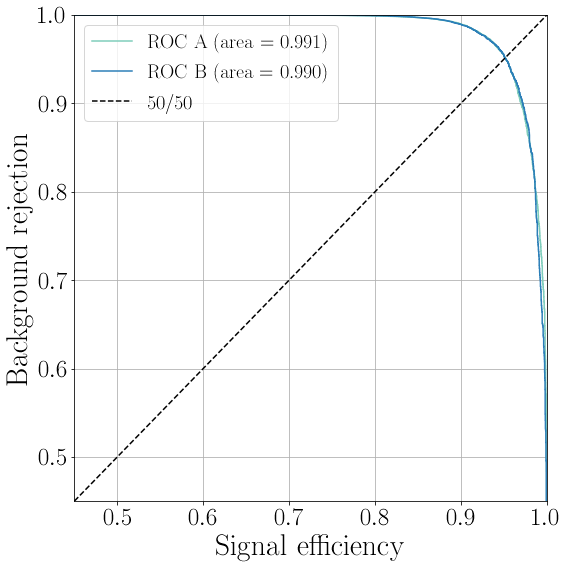

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(tpr_A, 1-fpr_A, lw=1.5, color="#7fcdbb", label='ROC A (area = %0.3f)'%(roc_auc_A))
plt.plot(tpr_B, 1-fpr_B, lw=1.5, color="#2c7fb8", label='ROC B (area = %0.3f)'%(roc_auc_B))

plt.plot([0.45, 1.], [0.45, 1.], linestyle="--", color="k", label='50/50')
plt.xlim(0.45,1.)
plt.ylim(0.45,1.)
plt.ylabel('Background rejection',fontsize=30)
plt.xlabel('Signal efficiency',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(loc="upper left",fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zbb_ROC.pdf")

In [66]:
#Get BDT scores
sig_A, sig_B = train_test_split(df_sig, test_size=0.5, random_state=10)
bkg_A, bkg_B = train_test_split(df_bkg, test_size=0.5, random_state=10)
sig_A_train_vars = sig_A[training_vars]
sig_B_train_vars = sig_B[training_vars]
bkg_A_train_vars = bkg_A[training_vars]
bkg_B_train_vars = bkg_B[training_vars]

sig_A["BDT_bb"] = bdt_B.predict_proba(sig_A_train_vars).tolist()
sig_B["BDT_bb"] = bdt_A.predict_proba(sig_B_train_vars).tolist()
bkg_A["BDT_bb"] = bdt_B.predict_proba(bkg_A_train_vars).tolist()
bkg_B["BDT_bb"] = bdt_A.predict_proba(bkg_B_train_vars).tolist()
sig_A['BDT_bb'] = sig_A['BDT_bb'].apply(lambda x: x[1] if isinstance(x, list) else x)
sig_B['BDT_bb'] = sig_B['BDT_bb'].apply(lambda x: x[1] if isinstance(x, list) else x)
bkg_A['BDT_bb'] = bkg_A['BDT_bb'].apply(lambda x: x[1] if isinstance(x, list) else x)
bkg_B['BDT_bb'] = bkg_B['BDT_bb'].apply(lambda x: x[1] if isinstance(x, list) else x)

/usr/local/bin/start_ipykernel.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:12: SettingWithCopyWarning: 
A value is 

In [67]:
#Combine the samples and plot signal and background BDTs
sig_tot = sig_A.append(sig_B)
bkg_tot = bkg_A.append(bkg_B)

In [73]:
#Find cut which keeps 1 background event i.e 10^-6 rejection
BDT_cut = 0.
n_bkg_tot = len(bkg_tot)
df_bkg_cut = bkg_tot.copy()
for i in range(0,10000):
    cut = float(i)/10000.
    df_bkg_cut = df_bkg_cut.query(f"BDT_bb > {cut}")
    n_bkg_cut = float(len(df_bkg_cut))
    if(n_bkg_cut == 1):
        BDT_cut = cut
        break

print("BDT cut that keeps 10^-6 bkg = %s" % BDT_cut)

#Signal efficiency at this BDT cut
n_sig_pass = float(len(sig_tot.query(f"BDT_bb > {BDT_cut}")))
eff_sig_pass = n_sig_pass / len(sig_tot)
print("Signal eff. for this cut = %s" % eff_sig_pass)

BDT cut that keeps 10^-6 bkg = 0.9948
Signal eff. for this cut = 0.6174725013848223


In [69]:
#KS tests for signal and background
ks_sig = ks_2samp(sig_A["BDT_bb"],sig_B["BDT_bb"])

ks_bkg = ks_2samp(bkg_A["BDT_bb"],bkg_B["BDT_bb"])

print(f"KS score for signal A vs. B: {ks_sig[0]}")
print(f"KS score for background A vs. B: {ks_bkg[0]}")

KS score for signal A vs. B: 0.0365259588589581
KS score for background A vs. B: 0.04769195973764219


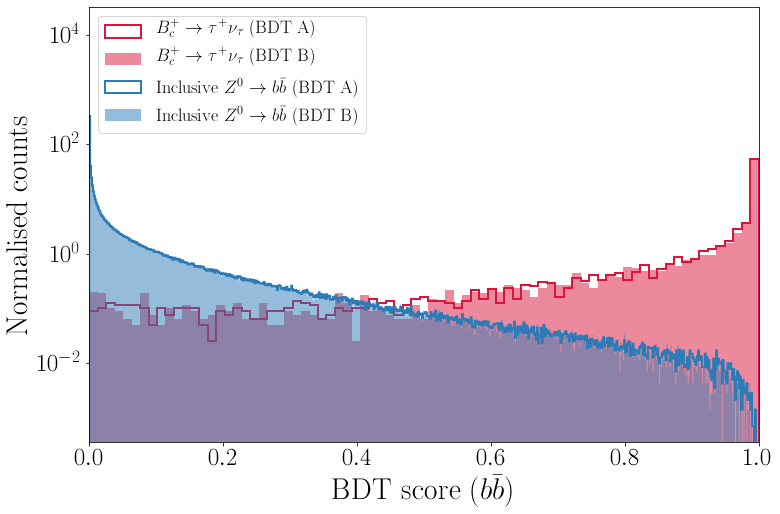

In [70]:
fig, ax = plt.subplots(figsize=(12,8))
xmin = 0
xmax = 1
bins_bkg = int(np.sqrt(len(bkg_A)))
bins_sig = int(np.sqrt(len(sig_A)))
plt.hist(sig_A["BDT_bb"],bins=bins_sig,range=(xmin,xmax),density=True,color="crimson",histtype='step',linewidth=2,label="$B_c^+ \\to \\tau^+ \\nu_\\tau$ (BDT A)")
plt.hist(sig_B["BDT_bb"],bins=bins_sig,range=(xmin,xmax),density=True,color="crimson",histtype='stepfilled',alpha=0.5,linewidth=2,label="$B_c^+ \\to \\tau^+ \\nu_\\tau$ (BDT B)")
plt.hist(bkg_tot["BDT_bb"],bins=bins_bkg,range=(xmin,xmax),density=True,color="#2c7bb6",histtype='step',linewidth=2,label="Inclusive $Z^0 \\to b\\bar{b}$ (BDT A)")
plt.hist(bkg_B["BDT_bb"],bins=bins_bkg,range=(xmin,xmax),density=True,color="#2c7bb6",histtype='stepfilled',alpha=0.5,linewidth=2,label="Inclusive $Z^0 \\to b\\bar{b}$ (BDT B)")
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(xmin,xmax)
plt.xlabel("BDT score ($b\\bar{b}$)",fontsize=30)
plt.ylabel("Normalised counts",fontsize=30)
plt.yscale('log')
ymin,ymax = plt.ylim()
plt.ylim(ymin,50*ymax)
plt.legend(fontsize=18, loc="upper left")
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zbb_BDT.pdf")

In [71]:
#Save signal sample to ROOT file
df_sig_out = read_root(f"{path}/Bc2TauNu_Zuds_BDT_Zcc_BDT.root","events")
train_vars = df_sig_out[training_vars]
df_sig_out["BDT_A"] = bdt_A.predict_proba(train_vars).tolist()
df_sig_out["BDT_A"] = df_sig_out["BDT_A"].apply(lambda x: x[1] if isinstance(x, list) else x)
df_sig_out["BDT_B"] = bdt_B.predict_proba(train_vars).tolist()
df_sig_out["BDT_B"] = df_sig_out["BDT_B"].apply(lambda x: x[1] if isinstance(x, list) else x)
df_sig_out["BDT_bb"] = 0.5*(df_sig_out["BDT_A"] + df_sig_out["BDT_B"])
df_sig_out = df_sig_out.drop("BDT_A",1)
df_sig_out = df_sig_out.drop("BDT_B",1)

root_file_name = f"{path}/Bc2TauNu_Zuds_BDT_Zcc_BDT_Zbb_BDT.root"
if os.path.exists(root_file_name):
    os.remove(root_file_name)
df_sig_out.to_root(root_file_name,"events")

In [72]:
#Also apply MVA to the Z -> qq and Z -> bb samples
for qq in ["uds","cc","bb"]:
    df_qq = read_root(f"{path}/inclusive_Z{qq}_Zuds_BDT_Zcc_BDT.root","events")
    train_vars = df_qq[training_vars]
    df_qq["BDT_A"] = bdt_A.predict_proba(train_vars).tolist()
    df_qq["BDT_A"] = df_qq["BDT_A"].apply(lambda x: x[1] if isinstance(x, list) else x)
    df_qq["BDT_B"] = bdt_B.predict_proba(train_vars).tolist()
    df_qq["BDT_B"] = df_qq["BDT_B"].apply(lambda x: x[1] if isinstance(x, list) else x)
    df_qq["BDT_bb"] = 0.5*(df_qq["BDT_A"] + df_qq["BDT_B"])
    df_qq = df_qq.drop("BDT_A",1)
    df_qq = df_qq.drop("BDT_B",1)
    root_file_name = f"{path}/inclusive_Z{qq}_Zuds_BDT_Zcc_BDT_Zbb_BDT.root"
    if os.path.exists(root_file_name):
        os.remove(root_file_name)
    df_qq.to_root(root_file_name,"events")